# PSF Experiment 2.0 - Moments / Finitediff

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#os
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#this is us
import autometacal as amc
import tensorflow_datasets as tfds
import tensorflow as tf

#...vs them!
import ngmix
import galsim
from multiprocessing import Pool

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Settings

In [3]:
g_psf =  array([0.01,0.0],dtype='float32')
rng = np.random.RandomState(31415)
stamp_size = 51
batch_size = 100
noise_level = .5e-5
shape_noise = 0
psf_noise_level = noise_level/1000
scale = 0.263
ncpus = 48
results_folder = "Results/amc_vs_ngmix"
settings_name = "anisotropic_psf_1em6_noise"

## Get to the Data!

In [4]:
data= tfds.load('simple/small_100k_noshear')
data = data['train'].cache()
data = data.batch(batch_size)
data = data.prefetch(tf.data.experimental.AUTOTUNE)

In [5]:
batchit = data.as_numpy_iterator()
onebatch = batchit.next()

## Create observations for ngmix

In [6]:
def observer(batch,shear_true):
  psf_fwhm = 0.7
  psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm).shear(g1=g_psf[0],g2=g_psf[1])
  psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
  psf_images = tf.repeat(psf_image,batch_size,axis=0)

  gal_images =amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([shear_true],
                                        len(onebatch['gal_model']),axis=0))

  noise_img = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  gal_images += noise_img
  psf_noise_img = np.random.normal(scale=psf_noise_level,size=[batch_size,stamp_size,stamp_size])
  psf_images += psf_noise_img
  obslist = []
  for im, psf_im in zip(gal_images,psf_images):
    cen = (np.array(im.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0

    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + 0/scale, col=cen[1] + 0/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )
    wt = im*0 + 1.0/noise_level**2
    psf_wt = psf_im*0 + 1.0/psf_noise_level**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )

    obs = ngmix.Observation(
        im,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    obslist += [obs]
  
  return obslist  

## Make the ngmix runner

In [7]:
def ngmix_booter_moments(rng,**kwargs):
  options = {
    'psf': 'dilate',
    'types': ['noshear', 
              '1p', '1m', '2p', '2m', '1p_psf', '1m_psf', '2p_psf', '2m_psf'
              ],
    'scale': scale,
        
  }

  weight_fwhm = 1.2
  fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
  psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

  # these "runners" run the measurement code on observations
  psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
  runner = ngmix.runners.Runner(fitter=fitter)

  # this "bootstrapper" runs the metacal image shearing as well as both psf
  # and object measurements
  #
  # We will just do R11 for simplicity and to speed up this example;
  # typically the off diagonal terms are negligible, and R11 and R22 are
  # usually consistent

  boot = ngmix.metacal.MetacalBootstrapper(
      runner=runner,
      psf_runner=psf_runner,
      rng=rng,
      psf=options['psf'],
      types=options['types'],
    fixnoise = False
  )
  return boot

boot = ngmix_booter_moments(rng)

...and run it:

In [8]:
def ngmix_step(obs):
  resdict, obsdict = boot.go(obs)
  return resdict, obsdict

## Extract the results

In [9]:
def get_metacal_response_ngmix(resdict):
  step=0.01

  #shear
  g0s = np.array([resdict['noshear']['g'][0], resdict['noshear']['g'][1]])
  g1p = np.array([resdict['1p']['g'][0], resdict['1p']['g'][1]])
  g1m = np.array([resdict['1m']['g'][0], resdict['1m']['g'][1]])
  g2p = np.array([resdict['2p']['g'][0], resdict['2p']['g'][1]])
  g2m = np.array([resdict['2m']['g'][0], resdict['2m']['g'][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  #PSF
  g1p_psf = np.array([resdict['1p_psf']['g'][0], resdict['1p_psf']['g'][1]])
  g1m_psf = np.array([resdict['1m_psf']['g'][0], resdict['1m_psf']['g'][1]])
  g2p_psf = np.array([resdict['2p_psf']['g'][0], resdict['2p_psf']['g'][1]])
  g2m_psf = np.array([resdict['2m_psf']['g'][0], resdict['2m_psf']['g'][1]])    
  
  R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
  R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
  R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
  R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,
    '1p_psf':g1p_psf,
    '1m_psf':g1m_psf,
    '2p_psf':g2p_psf,
    '2m_psf':g2m_psf,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  Rpsf = np.array(
    [[R11_psf,R12_psf],
     [R21_psf,R22_psf]])
    
  return ellip_dict, R, Rpsf

In [10]:
def get_metacal_response_ngmix_moments(resdict):
  step=0.01

  #shear
  g0s = np.array([resdict['noshear']['e'][0], resdict['noshear']['e'][1]])
  g1p = np.array([resdict['1p']['e'][0], resdict['1p']['e'][1]])
  g1m = np.array([resdict['1m']['e'][0], resdict['1m']['e'][1]])
  g2p = np.array([resdict['2p']['e'][0], resdict['2p']['e'][1]])
  g2m = np.array([resdict['2m']['e'][0], resdict['2m']['e'][1]])    
  
  R11 = (g1p[0]-g1m[0])/(2*step)
  R21 = (g1p[1]-g1m[1])/(2*step) 
  R12 = (g2p[0]-g2m[0])/(2*step)
  R22 = (g2p[1]-g2m[1])/(2*step)
  
  #PSF
  g1p_psf = np.array([resdict['1p_psf']['e'][0], resdict['1p_psf']['e'][1]])
  g1m_psf = np.array([resdict['1m_psf']['e'][0], resdict['1m_psf']['e'][1]])
  g2p_psf = np.array([resdict['2p_psf']['e'][0], resdict['2p_psf']['e'][1]])
  g2m_psf = np.array([resdict['2m_psf']['e'][0], resdict['2m_psf']['e'][1]])    
  
  R11_psf = (g1p_psf[0]-g1m_psf[0])/(2*step)
  R21_psf = (g1p_psf[1]-g1m_psf[1])/(2*step) 
  R12_psf = (g2p_psf[0]-g2m_psf[0])/(2*step)
  R22_psf = (g2p_psf[1]-g2m_psf[1])/(2*step)  
  
  ellip_dict = {
    'noshear':g0s,
    '1p':g1p,
    '1m':g1m,
    '2p':g2p,
    '2m':g2m,
    '1p_psf':g1p_psf,
    '1m_psf':g1m_psf,
    '2p_psf':g2p_psf,
    '2m_psf':g2m_psf,    
  } 
  
  R = np.array(
    [[R11,R12],
     [R21,R22]])

  Rpsf = np.array(
    [[R11_psf,R12_psf],
     [R21_psf,R22_psf]])
    
  return ellip_dict, R, Rpsf

In [11]:
def metacal_shear(e,R):
  return linalg.inv(R) @ e

def metacal_shear_psf(e,R,ep, Rp):
  return linalg.inv(R) @ (e - Rp @ ep)

def bootstraper(x,nboot):
  resample = random.randint(0,len(x),[nboot,len(x)])
  return x[resample].mean(axis=0)
  
def evaluator(ellips, R, g_psf, Rpsf):
  nboot=1000 #bootstraps make it look professional

  #uncorrected  
  resample = random.randint(0,batch_size,[nboot,batch_size])
  e = bootstraper(ellips,nboot).reshape(-1,2,1)
  R = bootstraper(R,nboot)
  Rp = bootstraper(Rpsf,nboot)

  shears = metacal_shear(e,R)
  shear = shears.mean(axis=0)
  shear_err = shears.std(axis=0)

  shearcorrs = metacal_shear_psf(e,R,g_psf.reshape(-1,2,1), Rp)
  shearcorr = shearcorrs.mean(axis=0)
  shearcorr_err = shearcorrs.std(axis=0)
  return shear[...,0], shear_err[...,0],  shearcorr[...,0], shearcorr_err[...,0]

## AutoMetaCal

We will run with a simple moments-based method for now.

In [12]:
_INTERPOLATOR = "bernsteinquintic"
from tensorflow_addons.image import resampler
 
def shearfunc(img,g1,g2,interpolation=_INTERPOLATOR):
  """
   Applies a shear g1, g2 on an image. 
   
   Args: 
     img: tf.tensor [batch,nx,ny,channels] float32
       batch of images
     g1, g2: shears to be applied
     
  Returns:
    sheared: tf.tensor [batch,nx,ny,channels]
      sheared image

  """
  
  _ , nx, ny, _ = img.get_shape().as_list()
  g1 = tf.convert_to_tensor(g1, dtype=tf.float32)
  g2 = tf.convert_to_tensor(g2, dtype=tf.float32)
  gsqr = g1**2 + g2**2
  
  # Building a batched jacobian
  jac = tf.stack([ 1. + g1, g2,
                g2, 1. - g1], axis=1) / tf.expand_dims(tf.sqrt(1.- gsqr),1)
  jac = tf.reshape(jac, [-1,2,2]) 

  # Inverting these jacobians to follow the TF definition
  if img.dtype == tf.complex64:
    transform_matrix = tf.transpose(jac,[0,2,1])
  else:
    transform_matrix = tf.linalg.inv(jac)
  
  #define a grid at pixel positions
  warp = tf.stack(tf.meshgrid(tf.linspace(0.,tf.cast(nx,tf.float32)-1.,nx), 
                              tf.linspace(0.,tf.cast(ny,tf.float32)-1.,ny)),axis=-1)[..., tf.newaxis]

  #get center
  center = tf.convert_to_tensor([[nx/2],[ny/2]],dtype=tf.float32)
  
  #displace center to origin
  warp = warp - center
  
  #if fourier, no half pixel shift needed
  warp -= int(img.dtype != tf.complex64)*.5

  #apply shear
  warp = tf.matmul(transform_matrix[:, tf.newaxis, tf.newaxis, ...], warp)[...,0]

  #return center
  warp = warp + center[...,0] 
 
  #if fourier, no half pixel shift needed
  warp -= int(img.dtype != tf.complex64)*.5
      
  #apply resampler
  if img.dtype == tf.complex64:
    a = resampler(tf.math.real(img),warp,interpolation)
    b = resampler(tf.math.imag(img),warp,interpolation)
    sheared = tf.complex(a,b)
  else:
    sheared = resampler(img,warp,interpolation)
  return sheared

In [13]:
def observer_amc(batch,shear_true,g_psf):
  """makes observations for amc from galaxy models"""
  psf_fwhm = 0.7
  psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm).shear(g1=g_psf[0],g2=g_psf[1])
  psf_image = tf.convert_to_tensor(psf.drawImage(nx=stamp_size, ny=stamp_size, scale=scale).array)[tf.newaxis]
  psf_images = tf.repeat(psf_image,batch_size,axis=0)

  gal_images =amc.noiseless_real_mcal_image(onebatch['gal_model'],
                                         psf_images,
                                         tf.repeat([shear_true],
                                        len(onebatch['gal_model']),axis=0))

  noise_img = np.random.normal(scale=noise_level,size=[batch_size,stamp_size,stamp_size])
  gal_images += noise_img
  psf_noise_img = np.random.normal(scale=psf_noise_level,size=[batch_size,stamp_size,stamp_size])
  psf_images += psf_noise_img
  
  return gal_images, psf_images  
gal_images, psf_images = observer_amc(onebatch,array([0.01,.0],dtype='float32'),g_psf)

## GalFlow

In [14]:
def dilate(img,factor,interpolator=_INTERPOLATOR):
  """ Dilate images by some factor, preserving the center. 
  
  Args:
    img: tf tensor containing [batch_size, nx, ny, channels] images
    factor: dilation factor (factor >= 1)
  
  Returns:
    dilated: tf tensor containing [batch_size, nx, ny, channels] images dilated by factor around the centre
  """
  img = tf.convert_to_tensor(img,dtype=tf.float32)
  batch_size, nx, ny, _ = img.get_shape()

  #x
  sampling_x = tf.linspace(0.,tf.cast(nx,tf.float32)-1.,nx)[tf.newaxis]
  centred_sampling_x = sampling_x - nx//2
  batched_sampling_x = tf.repeat(centred_sampling_x,batch_size,axis=0)
  rescale_sampling_x = tf.transpose(batched_sampling_x) / factor
  reshift_sampling_x = tf.transpose(rescale_sampling_x)+nx//2
  #y
  sampling_y = tf.linspace(0.,tf.cast(ny,tf.float32)-1.,ny)[tf.newaxis]
  centred_sampling_y = sampling_y - ny//2
  batched_sampling_y = tf.repeat(centred_sampling_y,batch_size,axis=0)
  rescale_sampling_y = tf.transpose(batched_sampling_y) / factor
  reshift_sampling_y = tf.transpose(rescale_sampling_y)+ny//2

  meshx = tf.transpose(tf.repeat([reshift_sampling_x],nx,axis=0),[1,0,2])
  meshy = tf.transpose(tf.transpose(tf.repeat([reshift_sampling_y],ny,axis=0)),[1,0,2])
  warp = tf.transpose(tf.stack([meshx,meshy]),[1,2,3,0])

  dilated= resampler(img,warp,interpolator)
  
  return tf.transpose(tf.transpose(dilated) /factor**2)

## AutoMetaCal

In [15]:
def makekpsf(psf,dtypes='complex64'):
  psf_complex = tf.cast(psf, dtype=dtypes)
  psf_fft = tf.signal.fft2d(psf_complex)
  psf_fft_abs = tf.abs(psf_fft)
  psf_fft_abs_complex = tf.cast(psf_fft_abs,dtype=dtypes)
  kpsf = tf.signal.fftshift(psf_fft_abs_complex,axes=[1,2])
  
  return kpsf

def makekimg(img,dtypes='complex64'):
  im_shift = tf.signal.ifftshift(img,axes=[1,2]) # The ifftshift is to remove the phase for centered objects
  im_complex = tf.cast(im_shift, dtypes)
  im_fft = tf.signal.fft2d(im_complex)
  imk = tf.signal.fftshift(im_fft, axes=[1,2])#the fftshift is to put the 0 frequency at the center of the k image
  return imk
  
pix=galsim.Pixel(scale=.263)
kpix = pix.drawImage(nx=153,ny=153).array
kpix = tf.convert_to_tensor(kpix,dtype='complex64')
kpix= tf.repeat([kpix],batch_size,axis=0)

invpix=galsim.Deconvolve(pix)
kinvpix = invpix.drawKImage(nx=153,ny=153).array
kinvpix = tf.convert_to_tensor(kinvpix,dtype='complex64')
kinvpix= tf.repeat([kinvpix],batch_size,axis=0)

def generate_mcal_image(gal_images,
                        psf_images,
                        #reconvolution_psf_images,
                        g, gp,
                        padfactor=1):
  """ Generate a metacalibrated image given input and target PSFs.
  
  Args: 
    gal_images: tf.Tensor or np.array
      (batch_size, N, N ) image of galaxies
    psf_images: tf.Tensor or np.array
      (batch_size, N, N ) image of psf model
    reconvolution_psf_image: tf.Tensor
      (N, N ) tensor of reconvolution psf model
    g: tf.Tensor or np.array
    [batch_size, 2] input shear
  Returns:
    img: tf.Tensor
      tf tensor containing image of galaxy after deconvolution by psf_deconv, 
      shearing by g, and reconvolution with reconvolution_psf_image.
  
  """
  #cast stuff as float32 tensors
  batch_size, nx, ny = gal_images.get_shape().as_list() 
  g = tf.convert_to_tensor(g, dtype=tf.float32)  
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)  
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  #reconvolution_psf_image = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  
  #dilate reconvolution psf
  #dilate_fact = 1. + 2.*tf.math.abs(tf.reduce_sum(g**2,axis=1))
  #reconvolution_psf_image = dilate(reconvolution_psf_image[...,tf.newaxis],dilate_fact)[...,0]
  
  #pad images
  fact = padfactor #how many image sizes to one direction
  paddings = tf.constant([[0, 0,], [nx*fact, nx*fact], [ny*fact, ny*fact]])
  gal_images = tf.pad(gal_images,paddings)
  psf_images = tf.pad(psf_images,paddings)
  
  
  #make masks
  kx, ky = tf.meshgrid(tf.linspace(-0.5,0.5,(2*padfactor+1)*nx),
                       tf.linspace(-0.5,0.5,(2*padfactor+1)*ny))
  mask = tf.cast(tf.math.sqrt(kx**2 + ky**2) <= 0.5, dtype='complex64')
  mask = tf.expand_dims(mask, axis=0)
  
  #Convert galaxy images to k space
  imk = makekpsf(gal_images)*mask

  #Convert psf images to k space  
  kpsf = makekpsf(psf_images)*mask


  # Deconvolve image from input PSF
  im_deconv = imk /(kpsf+1e-10)  
  
  #dilate reconvolution psf
  dilate_fact = 1. + 2.*tf.math.abs(tf.reduce_sum(g**2,axis=1))
  reconvolution_psf_image = dilate(psf_images[...,tf.newaxis],dilate_fact)[...,0]
  
  #pad reconv psf
  reconvolution_psf_images = tf.pad(reconvolution_psf_image,paddings)
  kpsf = makekimg(reconvolution_psf_image)*mask
  
  #remove pixel from reconv psf
  #kpsf *= kinvpix

  # Apply shear to the  deconv image
  im_sheared = shearfunc(tf.expand_dims(im_deconv,-1), g[...,0], g[...,1])[...,0]  

  # Apply shear to the  kpsf image
  krpsf_sheared = shearfunc(tf.expand_dims(kpsf,-1), gp[...,0], gp[...,1])[...,0]

  # Reconvolve with target PSF
  im_reconv = tf.signal.ifft2d(tf.signal.ifftshift(im_sheared * krpsf_sheared))

  # Compute inverse Fourier transform
  img = tf.math.real(tf.signal.fftshift(im_reconv))
  
  return img[:,fact*nx:-fact*nx,fact*ny:-fact*ny]

In [16]:
def get_metacal_response(gal_images,
                         psf_images,
                         #reconvolution_psf_image,
                         method):
  """
  Convenience function to compute the shear response
  """  
  gal_images = tf.convert_to_tensor(gal_images, dtype=tf.float32)
  psf_images = tf.convert_to_tensor(psf_images, dtype=tf.float32)
  batch_size, _ , _ = gal_images.get_shape().as_list()
  gs = tf.zeros([batch_size, 4])
  epsf = method(psf_images)
  with tf.GradientTape() as tape:
    tape.watch(gs)
    # Measure ellipticity under metacal
    e = method(generate_mcal_image(gal_images,
                                   psf_images,
                                   #reconvolution_psf_image,
                                   gs[:,0:2],gs[:,2:4]))

  Rs = tape.batch_jacobian(e, gs) 
  R, Rpsf = Rs[...,0:2], Rs[...,2:4]
  return e, epsf, R, Rpsf

In [17]:
#AutoMetaCal runner
method = lambda im: amc.get_moment_ellipticities(im, scale=scale, fwhm=1.2)

#for amc
@tf.function
def response(gal_images,psf_images):
  return get_metacal_response(gal_images, psf_images,method)


In [18]:
e_amc, e_psf, R_auto, R_psf = get_metacal_response(gal_images, 
                                                   psf_images,
                                                   #psf_images,
                                                   method)

In [19]:
shear, shear_err, shearcorr, shearcorr_err= evaluator(e_amc.numpy(), R_auto.numpy() ,e_psf.numpy(), R_psf.numpy())

In [20]:
print('AutoMetaCal')
print('-------------------------------------------------')
print('With psf correction:')
print(f"shear: {shearcorr[0]:.5f} +/- {shearcorr_err[0]*3:.8f} (99.7%% conf)")
print('-------------------------------------------------')
print('Without psf correction:')
print(f"shear: {shear[0]:.5f} +/- {shear_err[0]*3:.8f} (99.7%% conf)")


AutoMetaCal
-------------------------------------------------
With psf correction:
shear: 0.00880 +/- 0.00000926 (99.7%% conf)
-------------------------------------------------
Without psf correction:
shear: 0.01900 +/- 0.00000923 (99.7%% conf)


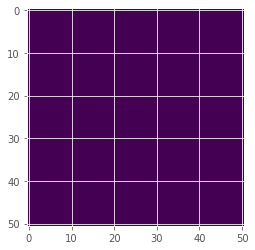

In [41]:
imshow(pix.drawImage(nx=51,ny=51).array)

In [76]:
pix.drawImage(nx=51,ny=51).array[0,0]

2.4674011e-06

In [80]:
637*637*2.4674011e-06

1.0011948769459

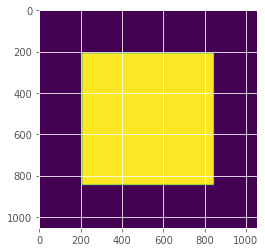

In [57]:
pix=galsim.Pixel(scale=.1)
imshow(pix.drawImage(nx=51,ny=51).array)

(200.0, 220.0)

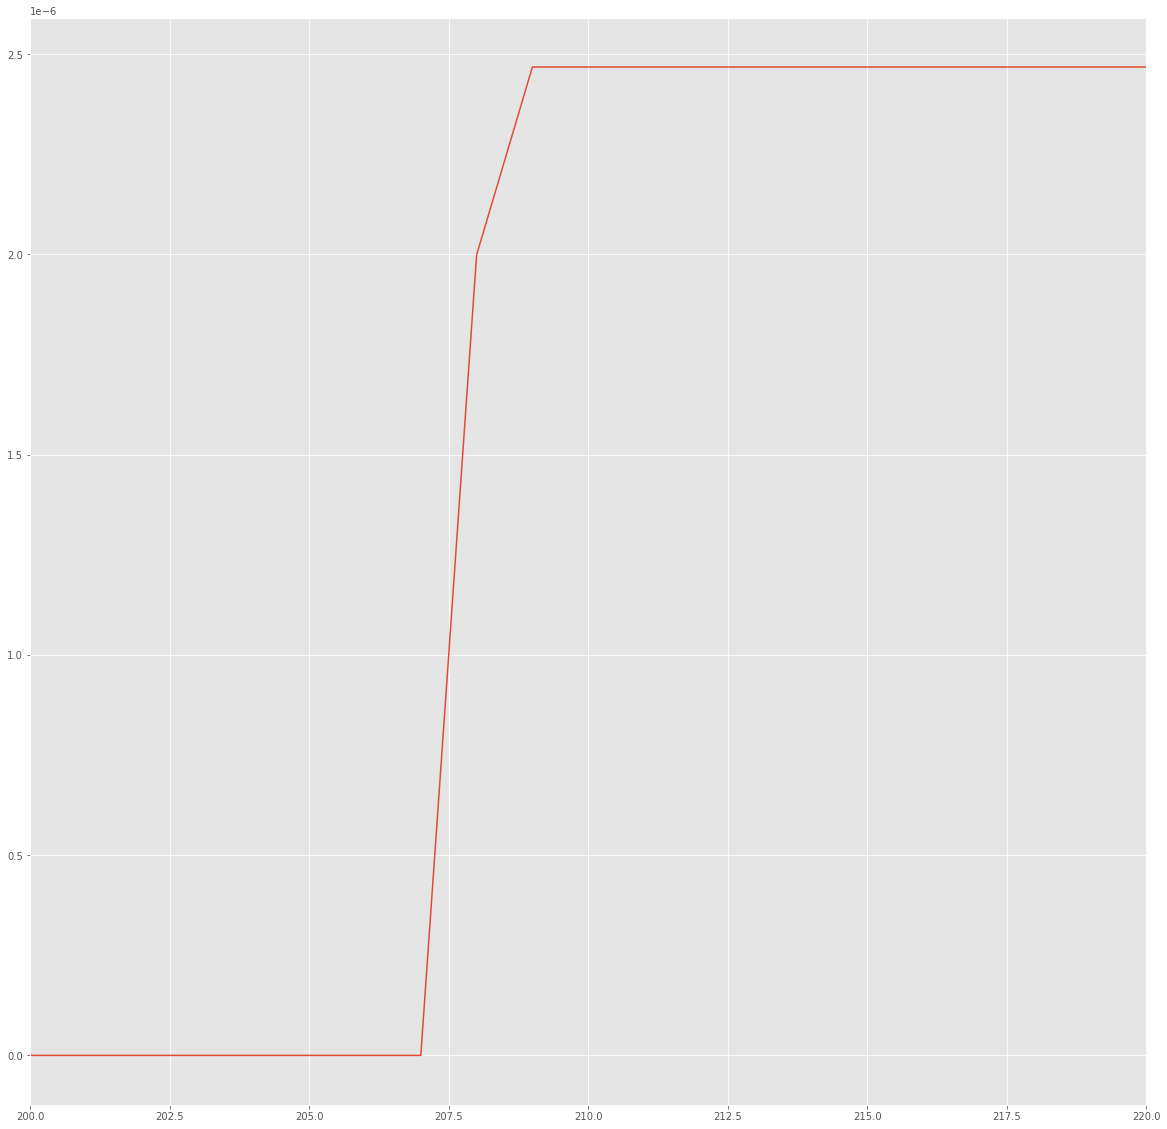

In [69]:
figure(figsize=(20,20))
plot(pix.drawImage(nx=1053,ny=1053).array[:,1053//2])
xlim(200,220)

In [60]:
testepix=pix.drawImage(nx=,ny=1053).array.reshape(1,1053,1053)

In [70]:
1053-206

847

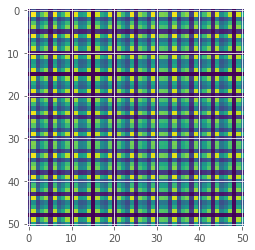

In [65]:
imshow(real(makekpsf(testepix))[0][1053-51:1053+51,1053-51:1053+51])

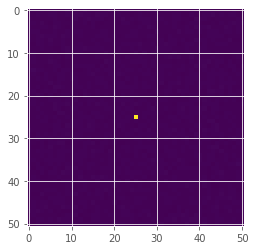

In [35]:
pixamc = random.uniform(1e-6,2e-6,[1,51,51])
pixtf =tf.convert_to_tensor(pixamc,dtype=tf.float32)
imshow(real(makekimg(pixtf)[0]));

## A few batches!

In [21]:
shear_range = linspace(-.02,.02,10)

shear_ngmix_list = []
shear_err_ngmix_list = []
shearcorr_ngmix_list = []
shearcorr_err_ngmix_list = []

shear_amc_list = []
shear_err_amc_list = []
shearcorr_amc_list = []
shearcorr_err_amc_list = []
import tqdm
for shear in tqdm.tqdm(shear_range):
  shear_true = array([shear,0.],dtype='float32')  
  
  #ngmix
  obslist = observer(onebatch,shear_true)

  pool = Pool(ncpus)
  dlist = pool.map(ngmix_step,obslist)
  pool.close()  
  
  #rextractor (Results Extractor! :))
  results = [get_metacal_response_ngmix_moments(result[0]) for result in dlist]
  
  
  ellips = array([result[0]['noshear'] for result in results])
  R = array([result[1] for result in results])
  Rpsf = array([result[2] for result in results])
  
  shear_ngmix, shear_err_ngmix, shearcorr_ngmix, shearcorr_err_ngmix= evaluator(ellips, 
                                                                                R,
                                                                                g_psf, 
                                                                                Rpsf)
  #AutoMetaCal
  gal_images, psf_images  = observer_amc(onebatch,shear_true,g_psf)
  
  e_amc, e_psf, R_auto, R_psf = response(gal_images, psf_images)
    
  shear_amc, shear_err_amc, shearcorr_amc, shearcorr_err_amc= evaluator(e_amc.numpy(), 
                                                                        R_auto.numpy() ,
                                                                        g_psf,#e_psf.numpy(), 
                                                                        R_psf.numpy())
  #gather results
  shear_ngmix_list += [shear_ngmix]
  shear_err_ngmix_list += [shear_err_ngmix]
  shearcorr_ngmix_list += [shearcorr_ngmix]
  shearcorr_err_ngmix_list += [shearcorr_err_ngmix]

  shear_amc_list += [shear_amc]
  shear_err_amc_list += [shear_err_amc]
  shearcorr_amc_list += [shearcorr_amc]
  shearcorr_err_amc_list += [shearcorr_err_amc]

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:11<00:00,  7.18s/it]


## Gather Results

In [22]:
from scipy.stats import linregress

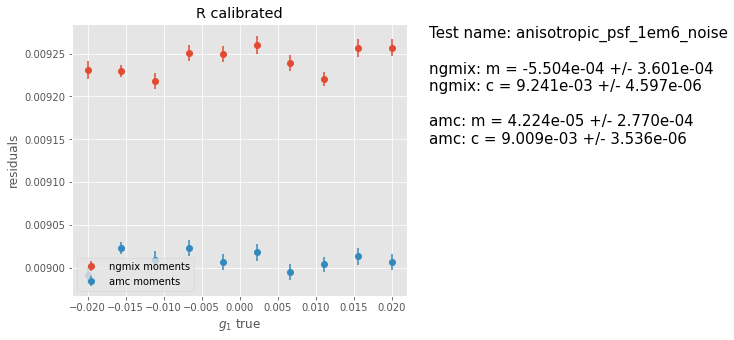

In [23]:
style.use('ggplot')
figure(figsize=(6,5))

X1 = shear_range
Y1 =  array(shear_ngmix_list)[:,0]
Y1err = array(shear_err_ngmix_list)[:,0]

#biases
ngmix_bias = linregress(X1,Y1)
m_ngmix = 1-ngmix_bias.slope
c_ngmix = ngmix_bias.intercept

#errors
m_ngmix_err = ngmix_bias.stderr
c_ngmix_err = ngmix_bias.intercept_stderr

plot_text = f"Test name: {settings_name}\n\n"

plot_text +=  f"ngmix: m = {m_ngmix:.3e} +/- {m_ngmix_err:.3e}\n"
plot_text += f"ngmix: c = {c_ngmix:.3e} +/- {c_ngmix_err:.3e}\n"


errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'ngmix moments')

Y1 =  array(shear_amc_list)[:,0] 
Y1err = array(shear_err_ngmix_list)[:,0]

m_amc = 1-linregress(X1,Y1)[0]
c_amc = linregress(X1,Y1)[1]

#biases
amc_bias = linregress(X1,Y1)
m_amc = 1-amc_bias.slope
c_amc = amc_bias.intercept

#errors
m_amc_err = amc_bias.stderr
c_amc_err = amc_bias.intercept_stderr

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'amc moments')

plot_text += f"\namc: m = {m_amc:.3e} +/- {m_amc_err:.3e}\n"
plot_text += f"amc: c = {c_amc:.3e} +/- {c_amc_err:.3e}\n"

figtext(.95,.5 ,plot_text,fontsize=15)

xlabel('$g_1$ true')
ylabel('residuals')

legend(loc=3)
title(f'R calibrated')
savefig(f'{results_folder}/uncorrected_shear_residuals_{settings_name}.jpg',bbox_inches='tight')

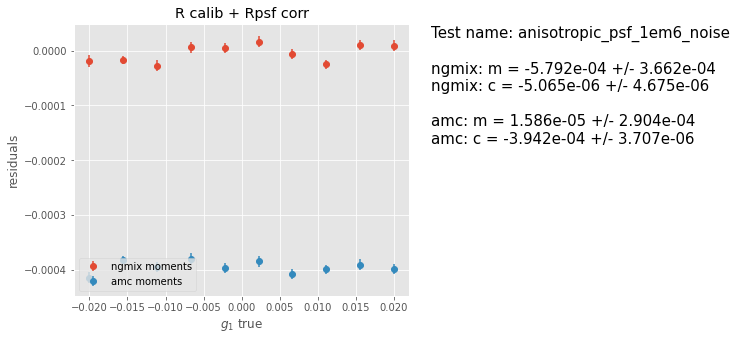

In [24]:
style.use('ggplot')
figure(figsize=(6,5))

X1 = shear_range
Y1 =  array(shearcorr_ngmix_list)[:,0]
Y1err = array(shearcorr_err_ngmix_list)[:,0]

#biases
ngmix_bias = linregress(X1,Y1)
m_ngmix = 1-ngmix_bias.slope
c_ngmix = ngmix_bias.intercept

#errors
m_ngmix_err = ngmix_bias.stderr
c_ngmix_err = ngmix_bias.intercept_stderr

plot_text = f"Test name: {settings_name}\n\n"

plot_text +=  f"ngmix: m = {m_ngmix:.3e} +/- {m_ngmix_err:.3e}\n"
plot_text += f"ngmix: c = {c_ngmix:.3e} +/- {c_ngmix_err:.3e}\n"


errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'ngmix moments')

Y1 =  array(shearcorr_amc_list)[:,0] 
Y1err = array(shearcorr_err_ngmix_list)[:,0]

m_amc = 1-linregress(X1,Y1)[0]
c_amc = linregress(X1,Y1)[1]

#biases
amc_bias = linregress(X1,Y1)
m_amc = 1-amc_bias.slope
c_amc = amc_bias.intercept

#errors
m_amc_err = amc_bias.stderr
c_amc_err = amc_bias.intercept_stderr

errorbar(X1,Y1 - X1,Y1err*3,fmt='o',label= 'amc moments')

plot_text += f"\namc: m = {m_amc:.3e} +/- {m_amc_err:.3e}\n"
plot_text += f"amc: c = {c_amc:.3e} +/- {c_amc_err:.3e}\n"

figtext(.95,.5 ,plot_text,fontsize=15)

xlabel('$g_1$ true')
ylabel('residuals')

legend(loc=3)
title(f'R calib + Rpsf corr')
savefig(f'{results_folder}/corrected_shear_residuals_{settings_name}.jpg',bbox_inches='tight')

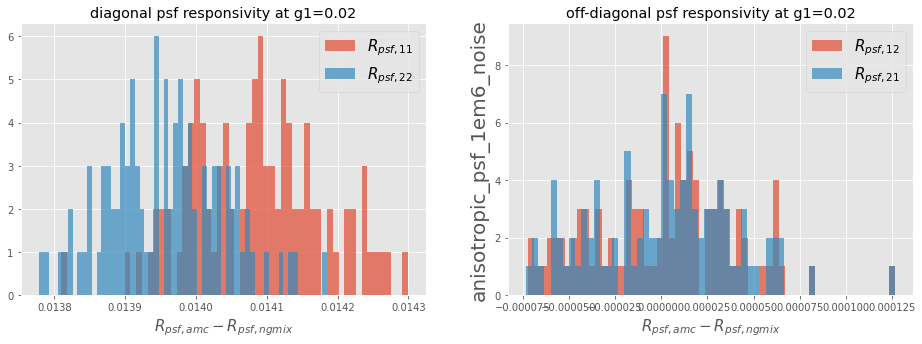

In [25]:
figure(figsize=(16,5))
subplot(121)
hist((R_psf - Rpsf)[:,0,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,11}$');
hist((R_psf - Rpsf)[:,1,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,22}$');
legend(fontsize=15)
xlabel('$R_{psf,amc} - R_{psf,ngmix}$',fontsize=15)
title(f'diagonal psf responsivity at g1={shear}')
subplot(122)
ylabel(settings_name,fontsize=20)
hist((R_psf - Rpsf)[:,0,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,12}$');
hist((R_psf - Rpsf)[:,1,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{psf,21}$');
legend(fontsize=15)
xlabel('$R_{psf,amc} - R_{psf,ngmix}$',fontsize=15)
title(f'off-diagonal psf responsivity at g1={shear}')
savefig(f'{results_folder}/Rpsf_{settings_name}.jpg',bbox_inches='tight')

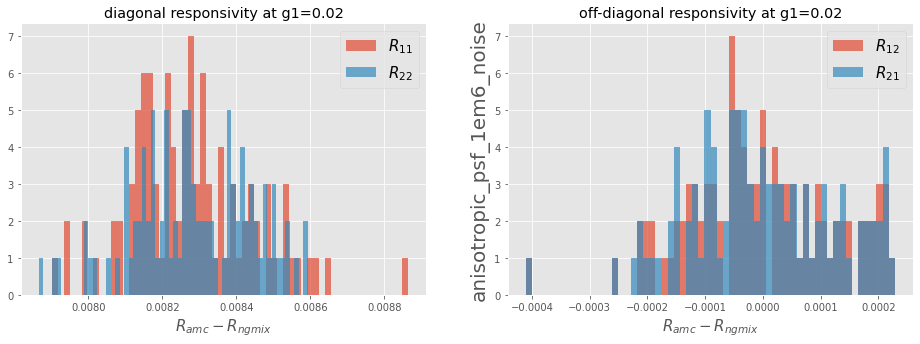

In [26]:
figure(figsize=(16,5))
subplot(121)
hist((R_auto - R)[:,0,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{11}$');
hist((R_auto - R)[:,1,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{22}$');
legend(fontsize=15)
xlabel('$R_{amc} - R_{ngmix}$',fontsize=15)
title(f'diagonal responsivity at g1={shear}')
subplot(122)
ylabel(settings_name,fontsize=20)
hist((R_auto - R)[:,0,1].numpy().flatten(),alpha=0.7,bins=60, label='$R_{12}$');
hist((R_auto - R)[:,1,0].numpy().flatten(),alpha=0.7,bins=60, label='$R_{21}$');
legend(fontsize=15)
xlabel('$R_{amc} - R_{ngmix}$',fontsize=15)
title(f'off-diagonal responsivity at g1={shear}')
savefig(f'{results_folder}/R_{settings_name}.jpg',bbox_inches='tight')

## Old Code